# Photometry FLMM Guide Part V: Interactions -- Probing Learning and Changes over Time
## Authors: Gabriel Loewinger, Erjia Cui
### 2024-09-07
### rpy2 implementation: Josh Lawrimore

# Part V: Probing Learning and Changes over Time

Neuroscience studies often use rich longitudinal experimental designs that allow the study of neural changes in signals over time. In previous sections, we saw a few simple examples of how to test whether the mean neural signal evolves across conditions, trials, or sessions (e.g., as a result of learning, satiation, etc). One might seek to go a step further and test whether a $signal-covariate~association$ (e.g., the correlation between the signal and latency-to-respond) changes over time. Testing these in the FLMM framework is straightforward and provides a couple additional benefits: 1) we can test these changes at every trial timepoint, 2) we can model between-animal, between-trial heterogeneity (in either the mean signal, or the signal - covariate association) with functional random effects, and 3) we can account for complex nested longitudinal designs that allow us to better identify patterns. This means that if the signal-covariate relationships change from trial-to-trial, between-animals, or between-conditions, we can model this explicitly with functional random effects. These functional random effects will then influence our statistical inference (through influencing the coefficient estimates and the width of our confidence intervals), thereby providing a rigorous and flexible statistical framework to characterize the richness in neural data across time.

So how do we test whether signal-covariate association levels change across time? One strategy is to model this with interactions between time (e.g., trial, session, conditions) and the variable of interest (CS+/CS-, behavior, treatment/control group). We have already seen how to model these separately, so now we just "put them together" in an interaction term, apply some of the tricks we have seen for interpretability, and interpret the coefficients appropriately. Just like the main effects, the joint 95% confidence intervals of the interaction terms will allow us to read statistical significance directly off the coefficient plots. To see this, let's use the datasets from previous parts to evaluate whether the $difference$ in average photometry signal to the CS+ vs. CS- changes across time. For example, perhaps as animals learn to better distinguish between the two cues (behaviorally), the average neural signals to the cues (CS+ and CS-) grow more different.

For demonstration purpose, we use data from the first 6 days (after switching from short delay days) of the long delay sessions from Test 4 of [Jeong et al., 2022](https://www.science.org/doi/full/10.1126/science.abq6740) and we thank the authors for generously making their data public and helping us analyze it.

## Considerations for modeling time

Part and parcel to the analysis questions posed above are decisions about how we model signal changes across time (e.g., trial number, session number), at a fixed trial timepoint. In the previous section, we saw one way of modeling time: treating session number as a factor. We could have, however, made many other choices: treating session number as continuous, including interactions between session and trial number, including non-linear functions of either of these variables (e.g., using polynomials or splines). We will start with a couple simple choices here, but if there is interest, we can create additional vignettes showing examples of more flexible specifications of time. Regardless of your modeling choices, our suggestion is that you seek a balance of model interpretability and model fit: sometimes more flexible model specifications yield superior fits, but also reduce model interpretability (e.g., what does it mean if there is a statistically significant interaction between the CS+/CS- cue variable and a cubic polynomial of trial number?). 

## Modeling

Let's fit a couple models, and start with a simple setting where we include only the first ($\texttt{session} = 1$) and last session ($\texttt{session} = 6$) in this example dataset, using the same $X^{(6)}_{ij} = 1$ to denote that the current session is the final $\texttt{session}$ ($\texttt{session} = 6$) and $X^{(6)}_{ij} = 0$ to denote that the current session is the first $\texttt{session}$ ($\texttt{session} = 1$). We adjust our CS+/CS- notation slightly from previous sections to more easily distinguish between the CS+/CS- stimulus covariates and the time covariates above: we use $\texttt{CS}_{ij} = 1$ to denote CS- trials and $\texttt{CS}_{ij} = 0$ to denote CS+ trials. We use the shorthand to denote the vector of covariates $\mathbf{X}_{ij} = [X^{(6)}_{ij}~~~\texttt{CS}_{ij}]^T$


In [ ]:
from rpy2.robjects import r

from fast_fmm_rpy2.fmm_run import fui
from fast_fmm_rpy2.plot_fui import plot_fui

r('library(dplyr)')
r(r'dat = read.csv("int_data.csv") %>% dplyr::filter(session %in% c(1,3))') # Sessions 1 and 3 only
# make session a factor variable
r('dat[,"session"] = factor(dat[,"session"])')  # set to factor variable
r('dat[,"session"] = relevel(dat[,"session"], ref = "1")') # set first session to reference level


For simplicity, let's start with a model that includes an animal-specific (functional) random intercept, and a second model with both an animal-specific random intercept and random slope for cue. We could have included random slopes for time or even random slopes for the interaction between cue and time, but let's save these decisions for subsequent discussions on random effect specification.

Model 1:
$$
\begin{aligned} 
& \mathbb{E}[Y_{ij}(s) \mid \mathbf{X}_{ij}, \boldsymbol{\gamma}_i(s)] =  \beta_0(s) + {\gamma}_{0,i}(s) + \texttt{CS}_{ij} \beta_1(s) + X^{(6)}_{ij} \beta_2 + X^{(6)}_{ij} \texttt{CS}_{ij} \beta_3 \notag 
\end{aligned} 
$$ 
Model 2:
$$
\begin{aligned} 
& \mathbb{E}[Y_{ij}(s) \mid \mathbf{X}_{ij}, \boldsymbol{\gamma}_i(s)] =  \beta_0(s) + {\gamma}_{0,i}(s) + \texttt{CS}_{ij} \left[\beta_1(s) + {\gamma}_{1}(s) \right ] + X^{(6)}_{ij} \beta_2 + X^{(6)}_{ij} \texttt{CS}_{ij} \beta_3 \notag 
\end{aligned} 
$$ 

We fit these with the following code, setting `parallel = TRUE` to speed up the code.


In [2]:
# fit two models
mod1 = fui(csv_filepath=None, formula='photometry ~ session * cs + (1 | id)', parallel=True, r_var_name='dat') # random intercept model
mod2 = fui(csv_filepath=None, formula='photometry ~ session * cs + (cs | id)', parallel=True, r_var_name='dat') # random intercept random slope model


R[write to console]: Number of cores used for parallelization: 10



[1] "Step 1: Fit Massively Univariate Mixed Models"
[1] "Step 2: Smoothing"
[1] "Step 3: Inference (Analytic)"
[1] "Step 3.1: Preparation"
[1] "Step 3.1.1: Method of Moments Covariance Estimator Random Intercept"
[1] "Step 3.1.2: Smooth G"
[1] "Step 3.2: First step"
[1] "Step 3.2.1: First step"
[1] "Step 3.3: Second step"


R[write to console]: Complete!
 - Use plot_fui() function to plot estimates.
 - For more information, run the command:  ?plot_fui

R[write to console]: Number of cores used for parallelization: 10



[1] "Step 1: Fit Massively Univariate Mixed Models"
[1] "Step 2: Smoothing"
[1] "Step 3: Inference (Analytic)"
[1] "Step 3.1: Preparation"
[1] "Step 3.1.1: Preparation B"
[1] "Step 3.1.1: Method of Moments Covariance Estimator"
[1] "Step 3.1.2: Smooth G"
[1] "Step 3.2: First step"
[1] "Step 3.2.1: First step"
[1] "Step 3.3: Second step"


R[write to console]: Complete!
 - Use plot_fui() function to plot estimates.
 - For more information, run the command:  ?plot_fui



As before, let’s compare the model fits of these two and choose the model with the superior (lower) AIC/BIC values.

In [3]:
# average pointwise model fits
mod1['aic'].mean() # worse model: higher AIC/BIC


AIC     3272.235801
BIC     3303.610484
cAIC            NaN
dtype: float64

In [4]:
mod2['aic'].mean() # superior model: lower AIC/BIC


AIC     3053.709413
BIC     3095.542324
cAIC            NaN
dtype: float64

Model 2 is superior, so let’s proceed with inference based on that model for now.

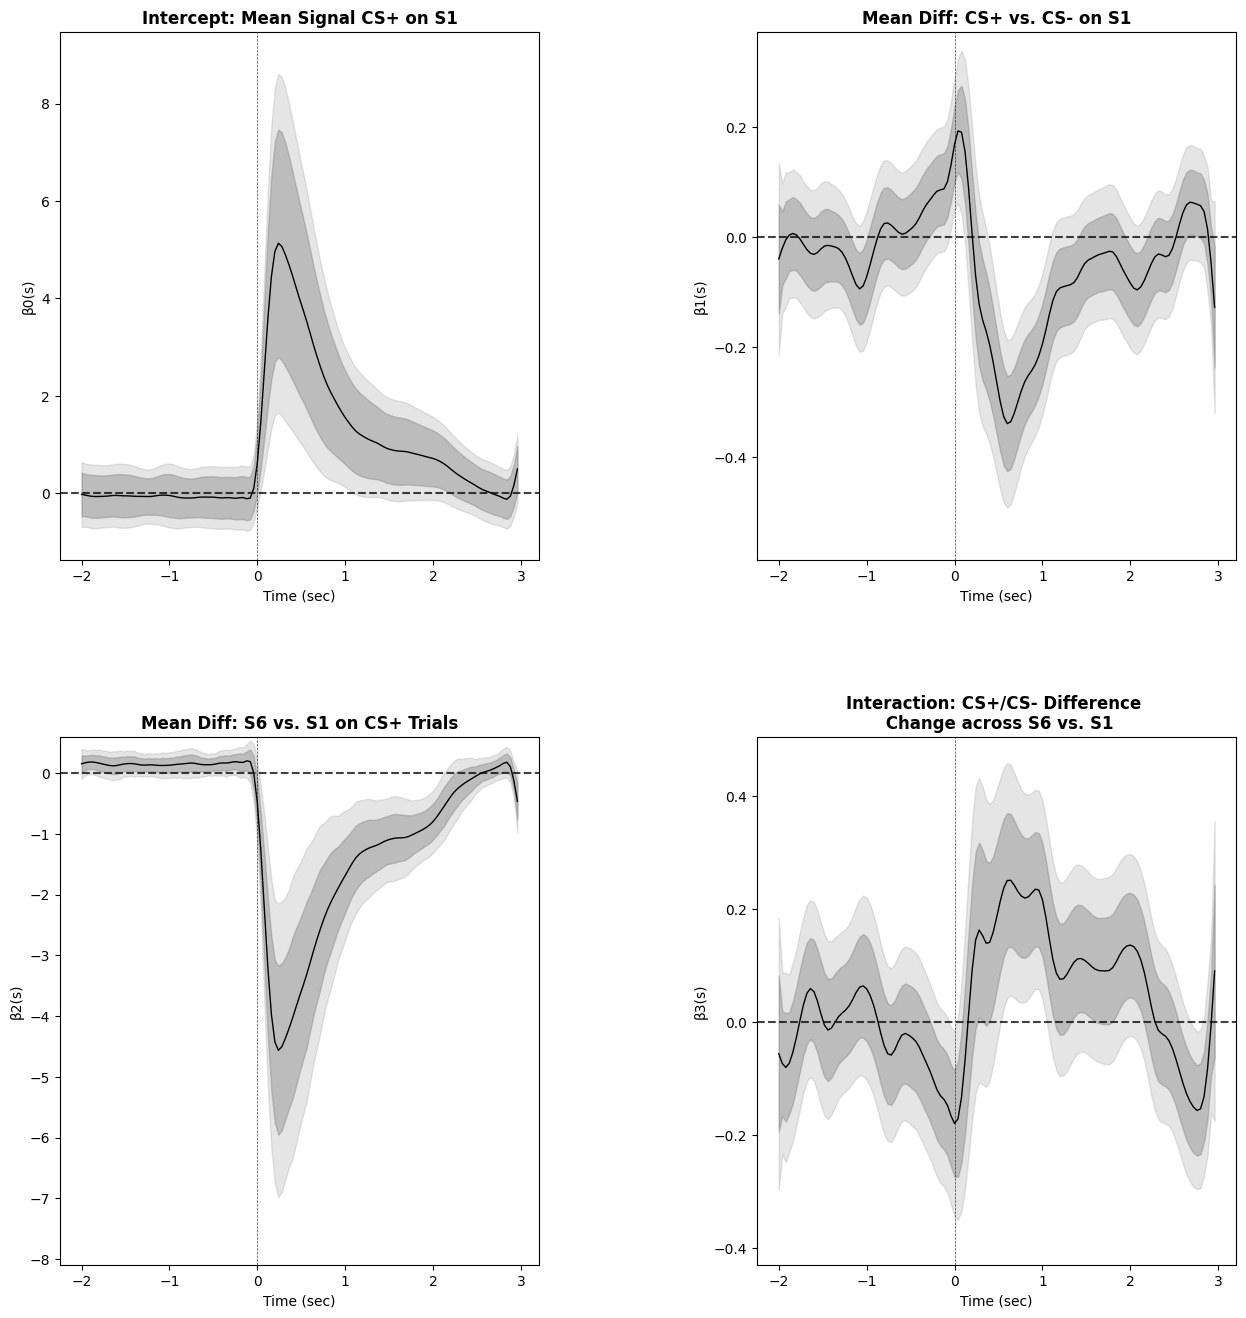

In [5]:
# plot model with best model fit (AIC/BIC)
figure = plot_fui(mod2, 
         xlab = "Time (sec)", # label x-axis
         x_rescale = 25, # rescale x-axis to be in sec - photometry sampled at 25 Hz 
         align_x = 2, # align to time of cue onset
         title_names = ["Intercept: Mean Signal CS+ on S1", "Mean Diff: CS+ vs. CS- on S1",
                         "Mean Diff: S6 vs. S1 on CS+ Trials", "Interaction: CS+/CS- Difference \n Change across S6 vs. S1"]
         )
figure.set_size_inches(14, 14)


The interpretation for the functional intercept at trial timepoint $s$ is "the mean signal on CS+ trials on Session 1 (S1) at timepoint $s$." The other functional fixed effect coefficient interpretations are complicated by the interaction term, so we first state their interpretations and then below we show algebraically why they have these interpretations For example, the estimate $\widehat{\beta}_1(s)$ has the interpretation as "the difference in average signal values between CS+/CS- trials on Session 1 at trial timepoint $s$." This has a similar main effect interpretation as we saw in the Part I on binary variables, but in this case the interpretation is specific to Session 1. This arises from the fact that the binary variable, $\texttt{CS}$, is also in an interaction term with the $\texttt{Session}$ variable, and thus their interpretations are "linked." Since we coded $\texttt{CS}_{ij} = 1$ to denote CS- trials, the initial significantly positive response right around cue onset (around 0 sec), indicates that the average signal is actually significantly higher on CS- trials than on CS+ trials (interestingly this effect really only lasts around a quarter of a second). Afterwards, we see that the mean signal is significantly higher on CS+ trials since the estimate $\widehat{\beta}_1(s)$ becomes negative at around $0.2$ seconds or so. 

This provides an example of the value of analyzing the signal at every trial timepoint: if we had analyzed the CS+/CS- effect with, for example, a t-test applied to AUCs, we may have missed the brief period of a significantly larger signal on CS- trials (i.e., the positive $\widehat{\beta}_1(s)$ around 0s-0.2s). It may have been drowned out by the longer and larger magnitude period when the average CS+ signal is larger (i.e., the negative $\widehat{\beta}_1(s)$ around 0.2s-1s).


The estimate $\widehat{\beta}_2(s)$ has the interpretation as "the mean difference in signal values between Sessions 6 (S6) and Session 1 at trial timepoint $s$ on CS+ trials." The interpretation here compares the difference between Sessions 1 and 6 on CS+ trials specifically, again because of the interaction. Finally, $\widehat{\beta}_3(s)$, the interaction term, shows the $change$ in the mean signal difference between CS+ and CS- trials from session 1 to session 6. More specifically, in the interval 0.5s-1s post-cue, we see that the difference in mean signals between CS+ and CS- trials is significantly larger on Session 6, than it is on Session 1. If animals learn to distinguish CS+ and CS- trials better from Session 1 to Session 6, we might expect the difference between the average signals on those trials to also grow larger with learning. This provides one strategy to conduct a hypothesis test evaluating how the effect of a covariate ($\texttt{CS}$: CS+ vs. CS-) on mean photometry values, changes across time.

## FLMM Coefficient Interpretation

We now outline the reasoning for the interpretations above. We explain the interpretations by starting with an algebraic representation of the interpretation, plug in the corresponding values into the model, simplify, and then show equality with the coefficient estimate. We apply some of the "tricks" we saw before: formulating our covariates to equal 0 at specific values to aid our interpretations. This allows us to "disentangle" interpreations for the functional main effects of covariates that are part of interaction terms.

### Main Effect Coefficient Interpretation

The reason the functional slopes have the interpretation as "the mean change in the photometry signal between level $r$ and the baseline level at trial timepoint $s$" can be seen through the same algebraic steps as we showed in Part I, since a factor variable is just expanded into a collection of $K-1$ binary variables (where $K$ is the total number of levels of the factor). For that reason, we will not repeat the algebra here. 

But why does the functional intercept have the interpretation as the average signal at the reference session on CS+ trials? Well, both CS+ and Session 1 define the reference levels of their respective coefficients. Remember, the functional intercept is always interpreted as the mean signal when all covariates are equal to 0. A factor is just expanded into $K-1$ binary variables indicating whether each observation occurred on a given session (vs. the baseline session), but is only encoded for the $K-1$ non-baseline/reference levels. For the reference level of the factor, all these binary variables equal 0. Thus the intercept has the interpretation as the mean on the reference level. 

### Interaction Term Coefficient Interpretations

The interaction term plot provides an estimate (and hypothesis test) of how much the effect of cue (CS+ vs. CS-) changes from Session 1 to Session 6. Why? Let's go through the algebra to build a little intuition. First, recall the $marginal$ model for reference,

$$
\begin{aligned} 
& \mathbb{E}[Y_{ij}(s) \mid \mathbf{X}_{ij}] =  \beta_0(s) + \texttt{CS}_{ij} \beta_1(s) + X^{(6)}_{ij} \beta_2 + X^{(6)}_{ij} \texttt{CS}_{ij} \beta_3. \notag 
\end{aligned} 
$$ 

Now let's plug in our interpretation for $\beta_3(s)$. Interactions have a difference-in-differences interpretation, which we explain below:
$$
\begin{align} 
&\left ( \mathbb{E}[Y_{ij}(s) \mid \texttt{CS}_{ij} = 1, X^{(6)}_{ij}= 1] - \mathbb{E}[Y_{ij}(s) \mid \texttt{CS}_{ij} = 0, X^{(6)}_{ij}= 1] \right ) - \left ( \mathbb{E}[Y_{ij}(s) \mid \texttt{CS}_{ij} = 1, X^{(6)}_{ij}= 0] - \mathbb{E}[Y_{ij}(s) \mid \texttt{CS}_{ij} = 0, X^{(6)}_{ij}= 0] \right ) \\
&=\left ( \beta_0(s) + {\beta}_1(s) + {\beta}_2(s) + {\beta}_3(s)  -\left [ \beta_0(s) - {\beta}_2(s) \right ]\right ) - \left ( \beta_0(s) + {\beta}_1(s) - [{\beta}_0(s)] \right ) \\
&=\beta_3(s).
\end{align} 
$$

The first difference (in the difference-in-differences) is between the average signal on CS- trials on Session 6, $\mathbb{E}[Y_{ij}(s) \mid \texttt{CS}_{ij} = 1, X^{(6)}_{ij}= 1]$, and the average signal on CS+ trials on Session 6, $\mathbb{E}[Y_{ij}(s) \mid \texttt{CS}_{ij} = 0, X^{(6)}_{ij}= 1]$. The second difference is between the average signal on CS- trials on Session 1, $\mathbb{E}[Y_{ij}(s) \mid \texttt{CS}_{ij} = 1, X^{(6)}_{ij}= 0]$, and the average signal on CS+ trials on Session 1, $\mathbb{E}[Y_{ij}(s) \mid \texttt{CS}_{ij} = 0, X^{(6)}_{ij}= 0]$. Thus, estimating the difference between these two $differences$, (i.e., $\beta_3(s)$), provides a formal way to evaluate whether the cue effect evolves across sessions.

The fact that the interaction term estimate, $\widehat{\beta}_3(s)$ is significantly positive from roughly 0.5s - 1.25s post cue-onset indicates that the difference between the CS+/CS- average signals is more positive on Session 6 than on Session 1 in that time interval. Remember we coded $\texttt{CS}_{ij} = 1$ to indicate CS- trials, and the signal is higher on CS+ trials. Thus this interaction shows that although the mean signal is larger on CS+ trials than on CS- trials on Session 6, that difference is significantly $smaller$ on Session 6 than it was on Session 1 (during that 0.5s-1.25s post cue-onset interval). Interestingly, there appears to be a very brief, and significant interaction effect right around cue-onset. This is another example of  an effect that would likely "wash out" if we analyzed this interaction with a summary measure (e.g., AUC).

# How to Cite
For use of this package or vignette, please cite the following papers:

Erjia Cui, Andrew Leroux, Ekaterina Smirnova, and Ciprian Crainiceanu. [Fast Univariate Inference for Longitudinal Functional Models](https://doi.org/10.1080/10618600.2021.1950006). Journal of Computational and Graphical Statistics (2022).

Gabriel Loewinger, Erjia Cui, David Lovinger, and Francisco Pereiera. [A Statistical Framework for Analysis of Trial-Level Temporal Dynamics in Fiber Photometry Experiments](https://www.biorxiv.org/content/10.1101/2023.11.06.565896v1). Biorxiv (2023).

# References

Doug Bates. [lme4: Mixed-effects modeling with R](https://stat.ethz.ch/~maechler/MEMo-pages/lMMwR.pdf) (2022).

Huijeong Jeong, Annie Taylor, Joseph Floeder, Martin Lohmann, Stefan Mihalas, Brenda Wu, Mingkang Zhou, Dennis Burke, Vijay Namboodiri. [Mesolimbic dopamine release conveys causal associations.](https://www.science.org/doi/full/10.1126/science.abq6740) Science 378, 6740 (2022).

Alexandra Kuznetsova, Per B. Brockhoff and Rune H. B. Christensen. [lmerTest Package:
Tests in Linear Mixed Effects Models](https://www.jstatsoft.org/article/view/v082i13). Journal of Statistical Software, 82(13), 1–26 (2017).

Russell V. Lenth, Ben Bolker, Paul Buerkner, Iago Giné-Vázquez, Maxime Herve, Maarten Jung, Jonathon Love, Fernando Miguez, Hannes Riebl, Henrik Singmann. [emmeans: Estimated Marginal Means, aka Least-Squares Means](https://cran.r-project.org/web/packages/emmeans/index.html).
